In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# load the dataset
df=pd.read_csv('merged_df.csv')
df.head()

C:\Users\polar\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


,Service:RDT-ID,date,Service:Type,Service:Company,Service:Train number,Service:Completely cancelled,Service:Partly cancelled,Service:Maximum delay,Stop:RDT-ID,Stop:Station code,...,Stop:Departure time,Stop:Departure delay,Stop:Departure cancelled,tavg,tmin,tmax,prcp,wdir,wspd,pres
0,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307596,SHL,...,2024-01-01T03:03:00+01:00,0.0,False,8.0,5.9,9.2,6.4,224.0,31.2,1000.0
1,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307597,ASS,...,2024-01-01T03:12:00+01:00,0.0,False,8.0,5.9,9.2,6.4,224.0,31.2,1000.0
2,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307598,ASD,...,2024-01-01T03:20:00+01:00,2.0,False,8.0,5.9,9.2,6.4,224.0,31.2,1000.0
3,12690865,2024-01-01,Intercity,NS,1410,False,False,0,114307599,ASB,...,2024-01-01T03:31:00+01:00,2.0,False,8.0,5.9,9.2,6.4,224.0,31.2,1000.0
4,12690867,2024-01-01,Intercity,NS,1409,False,False,0,114307611,ASB,...,2024-01-01T02:33:00+01:00,3.0,False,8.0,5.9,9.2,6.4,224.0,31.2,1000.0


In [2]:
df.index = df.date

In [3]:
df['Total Delay'] = df['Stop:Departure delay'] + df['Stop:Arrival delay']

In [4]:
filtered_delays = df[(df['Total Delay'] <= 30)
                                 ]

In [5]:
delay_df = filtered_delays[['Total Delay', 'tmin', 'tmax', 'date', 'wdir', 'wspd', 'prcp', 'pres']]

C:\Users\polar\AppData\Local\Temp\ipykernel_28064\3265913689.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delay_df['date'] = pd.to_datetime(delay_df['date'])


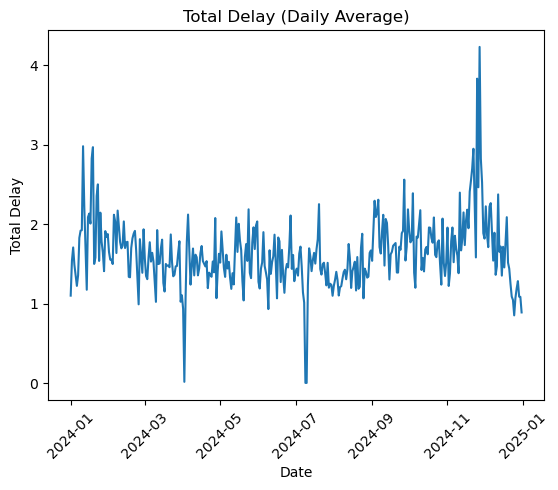

In [6]:
import pandas as pd
import matplotlib.pyplot as plt



# Convert the 'timestamp' column to datetime if it's not already
delay_df['date'] = pd.to_datetime(delay_df['date'])

# Set the 'timestamp' column as the index
delay_df.set_index('date', inplace=True)

# Resample the data (e.g., to daily frequency)
daily_delays = delay_df.resample('D').mean()  # 'D' for daily resampling

# Plot the resampled data
plt.plot(daily_delays.index, daily_delays['Total Delay'])
plt.title('Total Delay (Daily Average)')
plt.xlabel('Date')
plt.ylabel('Total Delay')
plt.xticks(rotation=45)
plt.show()

In [7]:
daily_delays.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2024-01-01 to 2024-12-31
Freq: D
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Delay  366 non-null    float64
 1   tmin         366 non-null    float64
 2   tmax         366 non-null    float64
 3   wdir         366 non-null    float64
 4   wspd         366 non-null    float64
 5   prcp         366 non-null    float64
 6   pres         366 non-null    float64
dtypes: float64(7)
memory usage: 22.9 KB


In [223]:
import numpy as np

def create_sequences(daily_delays, seq_length, forecast_horizon=30):
    X, y = [], []
    for i in range(len(daily_delays) - seq_length - forecast_horizon):
        # Use iloc to ensure proper index-based slicing
        X.append(daily_delays.iloc[i:i + seq_length].values)
        y.append(daily_delays.iloc[i + seq_length:i + seq_length + forecast_horizon]['Total Delay'].values)
    return np.array(X), np.array(y)

# Choose sequence length and forecast horizon
seq_length = 60  # Number of past timesteps to use for prediction
forecast_horizon = 30  # Number of days to forecast (next 30 days)

# Create sequences from the sampled data
X_train, y_train = create_sequences(daily_delays, seq_length, forecast_horizon)

In [224]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def transformer_encoder(input_seq, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention layer
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(input_seq, input_seq)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(input_seq + attention)
    
    # Feed-forward layer
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(input_seq.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(attention + ff)
    
    return ff

def build_transformer_model(seq_length, feature_dim, head_size=64, num_heads=4, ff_dim=128, num_layers=2, forecast_horizon=30):
    inputs = Input(shape=(seq_length, feature_dim))
    
    # Add transformer encoder layers
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    
    # Forecasting layer (fully connected)
    output = Dense(forecast_horizon)(x[:, -1, :])  # Using the last timestep for prediction
    
    model = Model(inputs, output)
    model.compile(optimizer="adam", loss="mse")
    
    return model

In [225]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Define parameters
seq_length = 60
forecast_horizon = 30
feature_dim = 7

# Create sequences
X, y = create_sequences(daily_delays, seq_length, forecast_horizon)

# Manually split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the model
model = build_transformer_model(seq_length, feature_dim, forecast_horizon=forecast_horizon)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

# Evaluate final score on both sets
train_score = model.evaluate(X_train, y_train, verbose=0)
val_score = model.evaluate(X_val, y_val, verbose=0)

print(f"\n✅ Final Training Loss: {train_score:.4f}")
print(f"✅ Final Validation Loss: {val_score:.4f}")


Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - loss: 2.1966 - val_loss: 2.9248
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.6723 - val_loss: 2.6901
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.5202 - val_loss: 2.5650
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.4137 - val_loss: 2.4245
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 1.2860 - val_loss: 2.2933
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.2101 - val_loss: 2.1676
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.1318 - val_loss: 2.0428
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 1.0290 - val_loss: 1.9254
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.9568 - val_loss: 1.8092
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.8506 - val_loss: 1.7047
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.8008 - val_loss: 1.5937
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.7226 - val_loss: 1.4981
E

In [123]:
# Change the input sequence to match the expected shape 
input_sequence = daily_delays.iloc[-60:].values.reshape(1, 60, 7)  # Last 30 days of data with 7 features

# Predict the delays for the next 30 days
predicted_delays = model.predict(input_sequence)
print(predicted_delays)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
[[1.53472   1.5527458 1.5434502 1.5382483 1.5346668 1.5442741 1.5506265
  1.5366278 1.5270817 1.5449724 1.5431175 1.5159088 1.5427077 1.5449867
  1.5314655 1.5294653 1.5266172 1.5323232 1.5354719 1.5350046 1.5376716
  1.5418003 1.5506673 1.5404955 1.5323344 1.538043  1.5294394 1.5431798
  1.5411408 1.5446761]]


In [28]:
# Station with most delays in time


# Group by station and sum delay minutes
station_delays = filtered_delays.groupby('Stop:Station name')['Total Delay'].sum()

# Sort to find the station with the highest total delay
most_delayed_station = station_delays.sort_values(ascending=False)

# Display the top station
print("Most delayed station (by total delay minutes):")
print(most_delayed_station.head(1))


Most delayed station (by total delay minutes):
Stop:Station name
Oss    604743.0
Name: Total Delay, dtype: float64


In [29]:
# Filter the original DataFrame
df_top_station = filtered_delays[filtered_delays['Stop:Station name'] == 'Oss']


In [30]:
top_delay_df = df_top_station[['Total Delay', 'tmin', 'tmax', 'date', 'wdir', 'wspd', 'prcp', 'pres']]

In [31]:
top_delay_df.head()

,Total Delay,tmin,tmax,date,wdir,wspd,prcp,pres
date,,,,,,,,
2024-01-01,2.0,5.7,8.6,2024-01-01,210.0,24.6,2.3,1001.6
2024-01-01,0.0,5.7,8.6,2024-01-01,210.0,24.6,2.3,1001.6
2024-01-01,4.0,5.7,8.6,2024-01-01,210.0,24.6,2.3,1001.6
2024-01-01,2.0,5.7,8.6,2024-01-01,210.0,24.6,2.3,1001.6
2024-01-01,0.0,5.7,8.6,2024-01-01,210.0,24.6,2.3,1001.6


C:\Users\polar\AppData\Local\Temp\ipykernel_28064\3642761273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_delay_df['date'] = pd.to_datetime(top_delay_df['date'])


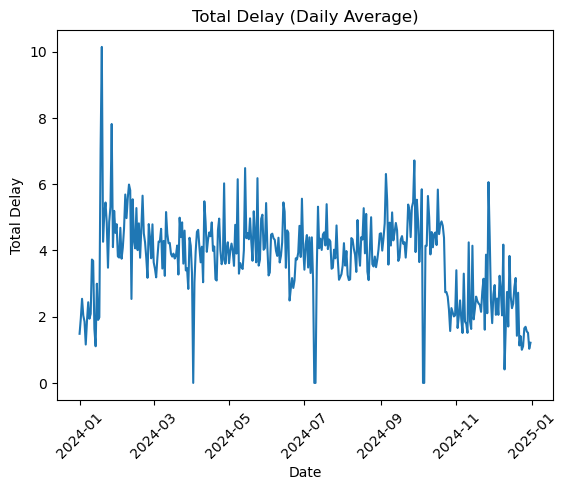

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'timestamp' column to datetime if it's not already
top_delay_df['date'] = pd.to_datetime(top_delay_df['date'])

# Set the 'timestamp' column as the index
top_delay_df.set_index('date', inplace=True)

# Resample the data (e.g., to daily frequency)
daily_delays = top_delay_df.resample('D').mean()  # 'D' for daily resampling

# Plot the resampled data
plt.plot(daily_delays.index, daily_delays['Total Delay'])
plt.title('Total Delay (Daily Average)')
plt.xlabel('Date')
plt.ylabel('Total Delay')
plt.xticks(rotation=45)
plt.show()

In [178]:
import numpy as np

def create_sequences(daily_delays, seq_length, forecast_horizon=30):
    X, y = [], []
    for i in range(len(daily_delays) - seq_length - forecast_horizon):
        # Use iloc to ensure proper index-based slicing
        X.append(daily_delays.iloc[i:i + seq_length].values)
        y.append(daily_delays.iloc[i + seq_length:i + seq_length + forecast_horizon]['Total Delay'].values)
    return np.array(X), np.array(y)

# Choose sequence length and forecast horizon
seq_length = 60  # Number of past timesteps to use for prediction
forecast_horizon = 30  # Number of days to forecast (next 30 days)

# Create sequences from the sampled data
X_train, y_train = create_sequences(daily_delays, seq_length, forecast_horizon)

In [179]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def transformer_encoder(input_seq, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention layer
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(input_seq, input_seq)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(input_seq + attention)
    
    # Feed-forward layer
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(input_seq.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(attention + ff)
    
    return ff

def build_transformer_model(seq_length, feature_dim, head_size=64, num_heads=4, ff_dim=128, num_layers=2, forecast_horizon=30):
    inputs = Input(shape=(seq_length, feature_dim))
    
    # Add transformer encoder layers
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    
    # Forecasting layer (fully connected)
    output = Dense(forecast_horizon)(x[:, -1, :])  # Using the last timestep for prediction
    
    model = Model(inputs, output)
    model.compile(optimizer="adam", loss="mse")
    
    return model

In [180]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Define parameters
seq_length = 60
forecast_horizon = 30
feature_dim = 7

# Create sequences
X, y = create_sequences(daily_delays, seq_length, forecast_horizon)

# Manually split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the model
model = build_transformer_model(seq_length, feature_dim, forecast_horizon=forecast_horizon)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

# Evaluate final score on both sets
train_score = model.evaluate(X_train, y_train, verbose=0)
val_score = model.evaluate(X_val, y_val, verbose=0)

print(f"\n✅ Final Training Loss: {train_score:.4f}")
print(f"✅ Final Validation Loss: {val_score:.4f}")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step - loss: 17.5729 - val_loss: 7.4565
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 15.8965 - val_loss: 7.0239
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 15.5925 - val_loss: 6.7725
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 15.1697 - val_loss: 6.5146
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 14.5318 - val_loss: 6.2658
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 14.0833 - val_loss: 6.0188
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 13.8806 - val_loss: 5.7663
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 13.4437 - val_loss: 5.5114
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.9670 - val_loss: 5.2561
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 12.3672 - val_loss: 5.0005
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 12.0646 - val_loss: 4.7500
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 11.4899 - val_lo

In [132]:
# Change the input sequence to match the expected shape (335 timesteps)
input_sequence = daily_delays.iloc[-60:].values.reshape(1, 60, 7)  # Last 60 days of data with 7 features

# Predict the delays for the next 30 days
predicted_delays = model.predict(input_sequence)
print(predicted_delays)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
[[2.5399494 3.6008518 2.7700222 3.0098217 2.9764762 1.6048377 2.6810887
  3.439536  2.2946281 2.5089536 2.9816506 1.6891001 2.7575474 3.8539488
  3.417276  2.624653  2.0621645 4.029093  2.4051788 3.2853127 2.997323
  1.834965  3.361016  3.582143  1.9171469 3.400331  2.2545693 2.1432781
  3.3389237 1.993613 ]]


In [181]:
# Station with most delays in time


# Group by station and sum delay minutes
station_delays = filtered_delays.groupby('Service:Train number')['Total Delay'].sum()

# Sort to find the station with the highest total delay
most_delayed_station = station_delays.sort_values(ascending=False)

# Display the top station
print("Most delayed station (by total delay minutes):")
print(most_delayed_station.head(1))

Most delayed station (by total delay minutes):
Service:Train number
6625    44932.0
Name: Total Delay, dtype: float64


In [182]:
# Filter the original DataFrame
df_top_train = filtered_delays[filtered_delays['Service:Train number'] == 6625]

In [183]:
top_delay_df = df_top_train[['Total Delay', 'tmin', 'tmax', 'date', 'wdir', 'wspd', 'prcp', 'pres']]

In [184]:
top_delay_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12523 entries, 2024-01-02 to 2024-10-26
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Total Delay  12523 non-null  float64
 1   tmin         12523 non-null  float64
 2   tmax         12523 non-null  float64
 3   date         12523 non-null  object 
 4   wdir         12523 non-null  float64
 5   wspd         12523 non-null  float64
 6   prcp         12523 non-null  float64
 7   pres         12523 non-null  float64
dtypes: float64(7), object(1)
memory usage: 880.5+ KB


C:\Users\polar\AppData\Local\Temp\ipykernel_6188\3642761273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_delay_df['date'] = pd.to_datetime(top_delay_df['date'])


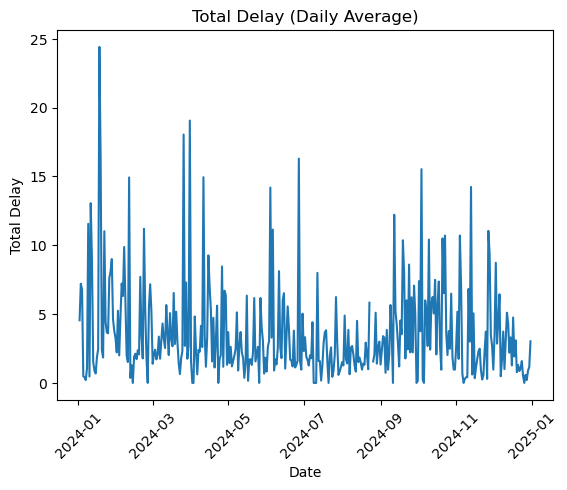

In [185]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert the 'timestamp' column to datetime if it's not already
top_delay_df['date'] = pd.to_datetime(top_delay_df['date'])

# Set the 'timestamp' column as the index
top_delay_df.set_index('date', inplace=True)

# Resample the data (e.g., to daily frequency)
daily_delays = top_delay_df.resample('D').mean()  # 'D' for daily resampling

# Plot the resampled data
plt.plot(daily_delays.index, daily_delays['Total Delay'])
plt.title('Total Delay (Daily Average)')
plt.xlabel('Date')
plt.ylabel('Total Delay')
plt.xticks(rotation=45)
plt.show()

In [186]:
daily_delays = daily_delays.fillna(method='ffill')

C:\Users\polar\AppData\Local\Temp\ipykernel_6188\990807587.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  daily_delays = daily_delays.fillna(method='ffill')


In [187]:
total_nans = daily_delays.isna().sum().sum()
print(f"Total NaNs in DataFrame: {total_nans}")


Total NaNs in DataFrame: 0


In [194]:
import numpy as np

def create_sequences(daily_delays, seq_length, forecast_horizon=30):
    X, y = [], []
    for i in range(len(daily_delays) - seq_length - forecast_horizon):
        # Use iloc to ensure proper index-based slicing
        X.append(daily_delays.iloc[i:i + seq_length].values)
        y.append(daily_delays.iloc[i + seq_length:i + seq_length + forecast_horizon]['Total Delay'].values)
    return np.array(X), np.array(y)

# Choose sequence length and forecast horizon
seq_length = 60  # Number of past timesteps to use for prediction
forecast_horizon = 30  # Number of days to forecast (next 30 days)

# Create sequences from the sampled data
X_train, y_train = create_sequences(daily_delays, seq_length, forecast_horizon)

In [195]:
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout
from tensorflow.keras.models import Model

def transformer_encoder(input_seq, head_size, num_heads, ff_dim, dropout=0.1):
    # Multi-head attention layer
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(input_seq, input_seq)
    attention = Dropout(dropout)(attention)
    attention = LayerNormalization(epsilon=1e-6)(input_seq + attention)
    
    # Feed-forward layer
    ff = Dense(ff_dim, activation="relu")(attention)
    ff = Dropout(dropout)(ff)
    ff = Dense(input_seq.shape[-1])(ff)
    ff = LayerNormalization(epsilon=1e-6)(attention + ff)
    
    return ff

def build_transformer_model(seq_length, feature_dim, head_size=64, num_heads=4, ff_dim=248, num_layers=2, forecast_horizon=30):
    inputs = Input(shape=(seq_length, feature_dim))
    
    # Add transformer encoder layers
    x = inputs
    for _ in range(num_layers):
        x = transformer_encoder(x, head_size, num_heads, ff_dim)
    
    # Forecasting layer (fully connected)
    output = Dense(forecast_horizon)(x[:, -1, :])  # Using the last timestep for prediction
    
    model = Model(inputs, output)
    model.compile(optimizer="adam", loss="mse")
    
    return model

In [196]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Define parameters
seq_length = 60
forecast_horizon = 30
feature_dim = 7

# Create sequences
X, y = create_sequences(daily_delays, seq_length, forecast_horizon)

# Manually split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build the model
model = build_transformer_model(seq_length, feature_dim, forecast_horizon=forecast_horizon)

# EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model.fit(X_train, y_train,
          epochs=50,
          batch_size=32,
          validation_data=(X_val, y_val),
          callbacks=[early_stopping])

# Evaluate final score on both sets
train_score = model.evaluate(X_train, y_train, verbose=0)
val_score = model.evaluate(X_val, y_val, verbose=0)

print(f"\n✅ Final Training Loss: {train_score:.4f}")
print(f"✅ Final Validation Loss: {val_score:.4f}")


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - loss: 23.6443 - val_loss: 21.7951
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 20.1242 - val_loss: 20.9900
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 20.3022 - val_loss: 20.7775
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 19.5247 - val_loss: 20.5025
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 19.4446 - val_loss: 20.1733
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 19.1809 - val_loss: 19.8650
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 19.8604 - val_loss: 19.5653
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 18.7527 - val_loss: 19.2666
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 18.6989 - val_loss: 18.9630
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 17.5105 - val_loss: 18.6539
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 18.3072 - val_loss: 18.3362
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 17.49

In [35]:
# Change the input sequence to match the expected shape (335 timesteps)
input_sequence = daily_delays.iloc[-60:].values.reshape(1, 60, 7)  # Last 60 days of data with 7 features

# Predict the delays for the next 30 days
predicted_delays = model.predict(input_sequence)
print(predicted_delays)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 491ms/step
[[3.3700876 3.145247  3.083215  3.2972007 3.3545241 2.943483  3.4440382
  3.1684504 2.5958207 2.9811778 2.7084587 2.3010318 3.2555985 2.4740531
  3.4427485 2.7323143 3.4201171 3.4402082 2.6563811 2.475038  3.3732913
  3.629274  3.029891  3.4858906 3.0639646 2.731113  3.4906452 3.1147044
  3.4967022 3.4899337]]
